<a href="https://colab.research.google.com/github/KANGWEII/hands_on_ml/blob/feature-chapter_2/Chapter02/end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2: End-to-End Machine Learning Project

## Getting Data

Function to fetch and load data

In [57]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets", filter="data")

  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

`info()` method is useful to get a quick description of the data

In [58]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`value_counts()` method is used to return the occurrences of each unique value within that Series in descending order of frequency

In [59]:
housing['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


`describe()` method shows a summary of the numerical attributes

In [60]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


`hist()` method plots a histogram for each numerical attribute

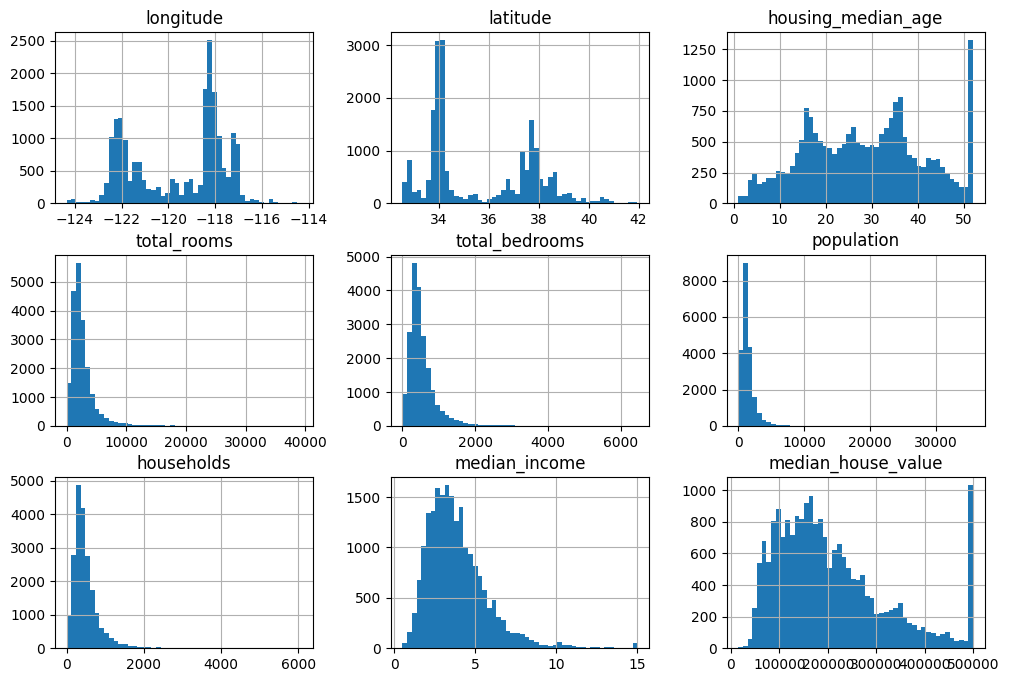

In [61]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12,8))
plt.show()

## Create a Test Set
- Typically 20% of the dataset (or less if the dataset is very large)

### Simple Split
- Re-running the program will generate different test set
- The model will get to see the whole dataset over time (test set becoming training set after re-running), aka data leakage
- This spliting method only works if the dataset is static and test set is separated into another folder

In [62]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]

  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set  = shuffle_and_split_data(housing, 0.2)

print(len(train_set), len(test_set))

16512 4128


### Random Seed
- If new data is added, re-running will shuffle the test set, old instances can move from train → test or test → train.
- Only work if the dataset is static

In [63]:
# Add before np.random.permutation()
# np.random.seed(42)


# ===================================================
# Example

X = np.arange(10)  # [0, 1, 2, ..., 9]

# Comment/Uncomment the following and rerun
np.random.seed(42)

# Get a random permutation of indices
perm = np.random.permutation(len(X))

# Split 80% train / 20% test
split = int(0.8 * len(X))
train_idx, test_idx = perm[:split], perm[split:]

X_train, X_test = X[train_idx], X[test_idx]

print("Train:", X_train)
print("Test:", X_test)

# ===================================================

Train: [8 1 5 0 7 2 9 4]
Test: [3 6]


### Hash-Based

- `crc32` is a 32-bit unsigned integer with output always in:

$$
0 ≤ crc32(index) ≤ 2^{32} - 1
$$

- The output of sequential numbers produce “random-looking” outputs
  ```
  for i in range(10):
    print(crc32(np.int64(i)))

  Output:
  1696784233
  2844319735
  654825492
  3954038922
  3781742995
  767742221
  2739787502
  1877464688
  3066545372
  2054014018
  ```



In [64]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))

  return data.loc[~in_test_set], data.loc[in_test_set]

# Adds an `index` column
housing_with_id = housing.reset_index()

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

- If using index as the unique identifier, make sure new data gets appended to the end of the dataset and no row ever gets deleted
- If it is not possible, use the most stable features to build the unique identifier

In [65]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

- `train_test_split` is a Scikit-Learn function that does similar function to `shuffle_and_split_data()` defined earlier, but with additional features
- `random_state` parameter allows for random generator seed input
- Same test set will be split everytime, provided that the dataset remains static

In [66]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Stratified Sampling

- Stratified sampling is a probability sampling technique that involves dividing a population into homogeneous subgroups, or "strata," based on shared characteristics like age or gender
- So far all the methods above are randomly sampled, which is fine if the dataset is large enough
- If it is not, there is risk of significant sampling bias

- eg. If the median income is very important attribute to predict median housing prices, it is crucial to ensure that the test set is representative of the various categories of incomes in the whole dataset
- `pd.cut()` function converts a continuous variable into categorical bins

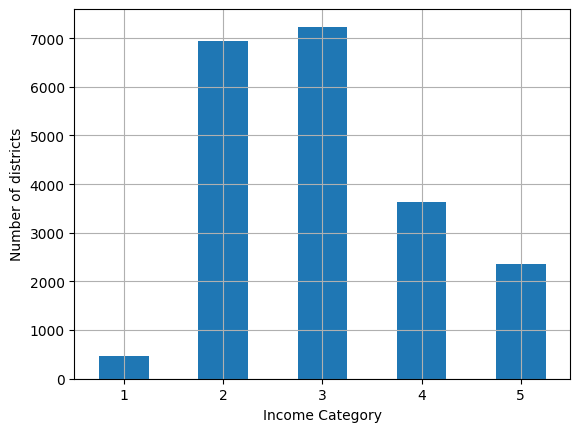

In [67]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.3, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

- With `n_splits=10` and 5 categories, we get 10 train/test pairs total
- Each of the 10 test/train splits contains all 5 categories, in approximately the same proportion
- Multiple splits will be discussed more in cross-validation later

In [68]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [69]:
strat_train_set, strat_test_set = strat_splits[0]

Shorter way to get a single split using the `train_test_split()` function with the stratify argument  

In [70]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

# Print income category proportions
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.336483
4,0.176357
5,0.114341
1,0.022287


In [71]:
# Remove `income_cat` column, reverting data back to its original state

for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

## Explore and Visualize Data

### Visualizing

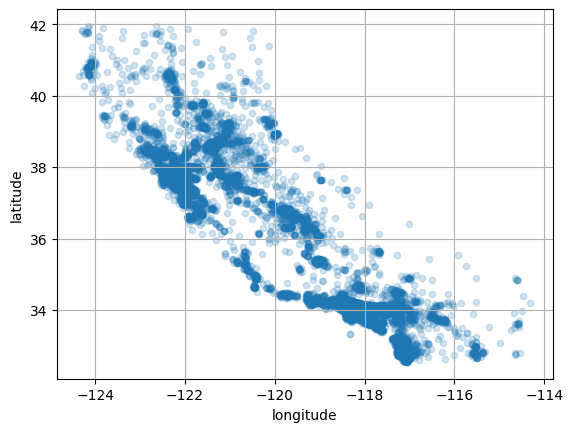

In [72]:
housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

- Red: Expensive
- Blue: Cheap
- Circle Radius: Population

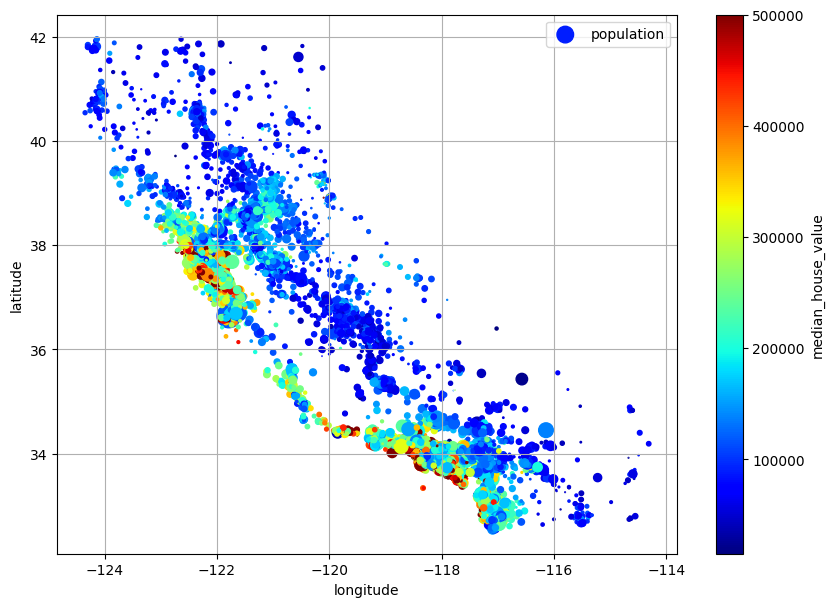

In [73]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex=False, figsize=(10,7))
plt.show()

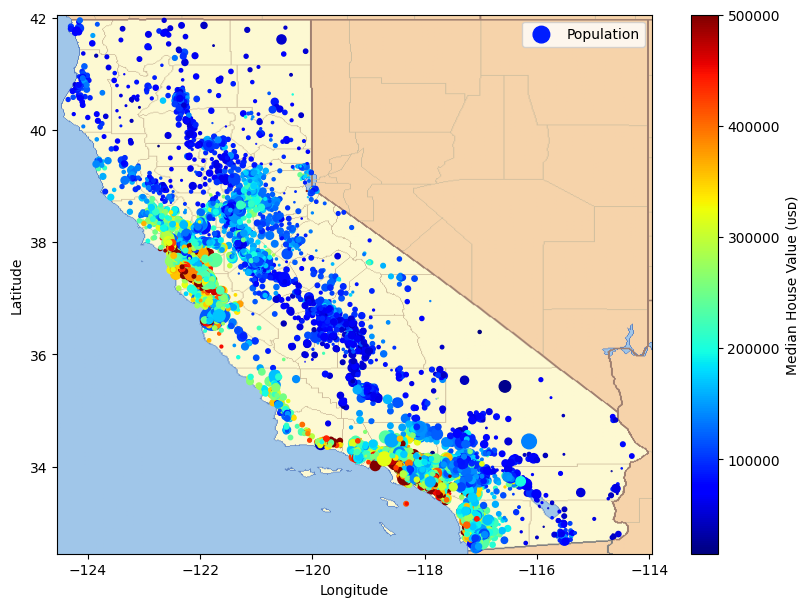

In [74]:
filename = "california.png"
url = "https://raw.githubusercontent.com/KANGWEII/hands_on_ml/feature-chapter_2/Chapter02/Img/" + filename

# Download directly into current working directory
urllib.request.urlretrieve(url, filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median House Value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median House Value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

### Look for Correlations

- Correlation coefficient ranges from -1 to 1:
  - +1 → perfect positive correlation (they increase together)
  - -1 → perfect negative correlation (one goes up, the other goes down)
  - 0 → no linear relationship

In [75]:
corr_matrix = housing.corr(numeric_only=True)

corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.689619
total_rooms,0.134812
housing_median_age,0.109507
households,0.067875
total_bedrooms,0.051101
population,-0.023249
longitude,-0.047655
latitude,-0.143788


- Pandas `scatter_matrix()` function
  - plots every numerical attribute against every other numerical attribute
  - and histogram of each numerical attribute (main diagonal)

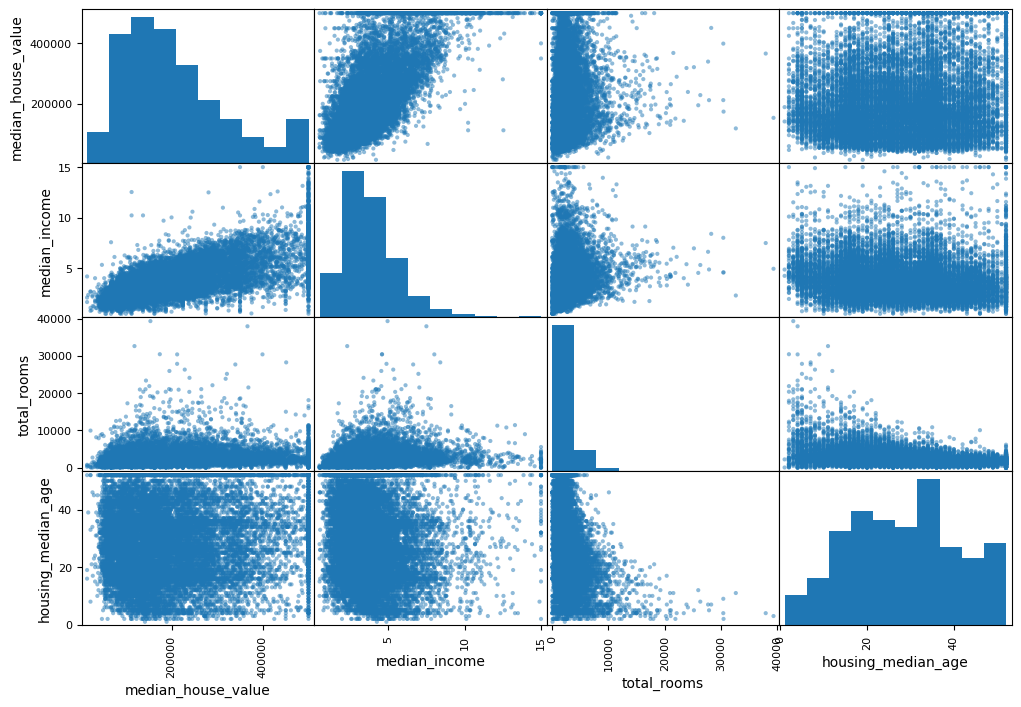

In [76]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

Looking at the scatterplots, seems like most promising attribute to predict median house value is median income
- Strong upward trend
- points are not too dispersed

Obvious straight lines at \$500000, \$450000, \$350000, and \$280000. May remove the corresponding districts to prevent algorithms from learning to reproduce data quirks

> **Data quirks:** unexpected, non-logical, or counter-intuitive aspects of a dataset or data system that can be challenging to understand or that may invalidate analysis without proper knowledge of the underlying context or system behavior

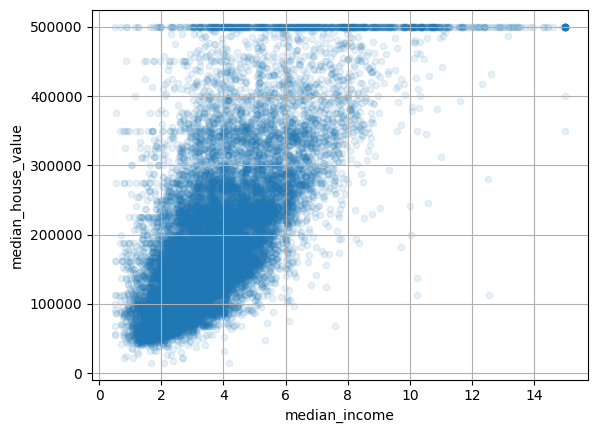

In [77]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

### Experiment with Attribute Combinations

In [78]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [79]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.689619
rooms_per_house,0.146157
total_rooms,0.134812
housing_median_age,0.109507
households,0.067875
total_bedrooms,0.051101
people_per_house,-0.019904
population,-0.023249
longitude,-0.047655


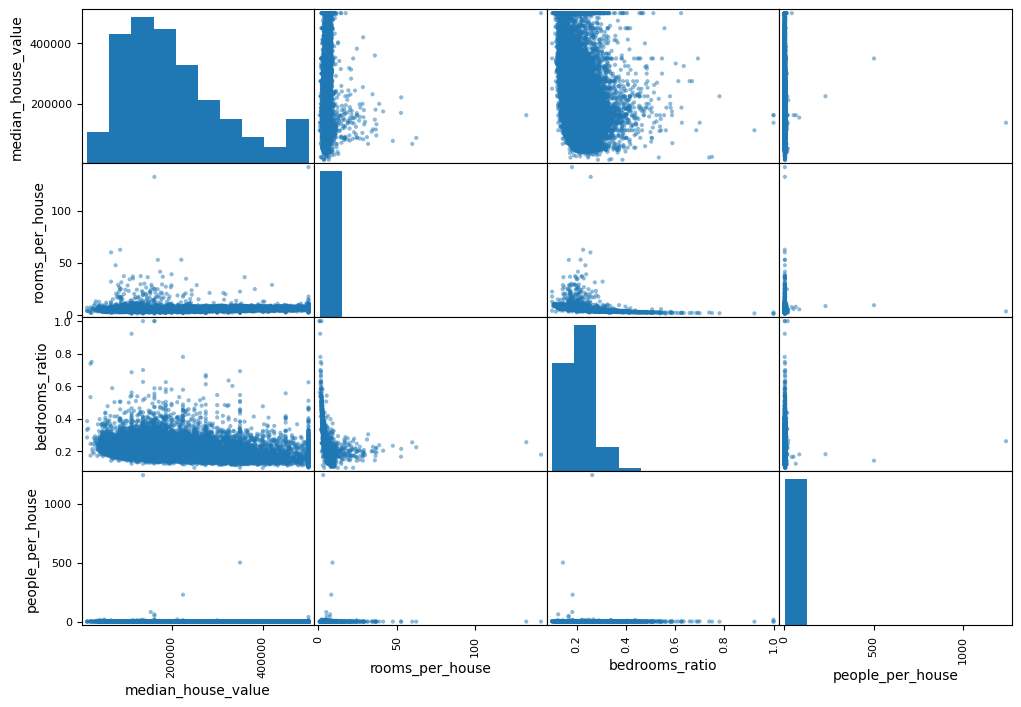

In [80]:
attributes = ["median_house_value", "rooms_per_house", "bedrooms_ratio", "people_per_house"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

## Prepare the Data for Machine Learning Algorithms

- Separate the predictors (features) and the labels (target), don't necessarily need to apply the same transformations to both
- `drop()` function create a copy of the data and does not affect `strat_train_set`
- housing = independent variables (longitude, latitude, median_income, etc.).
- housing_labels = dependent variable (the value we want to predict = house price).

In [81]:
# Removes the target column (median_house_value) from the DataFrame
housing = strat_train_set.drop("median_house_value", axis=1)

# Makes a safe copy so later modifications won’t affect the original strat_train_set
housing_labels = strat_train_set["median_house_value"].copy()

### Clean the Data

Most machine learning algorithms can't work with missing features, to fix:
1. Get rid of the corresponding districts
   - *housing.dropna(subset=["total_bedrooms], inplave=True)*
2. Get rid of the whole attribute
   - *housing.drop("total_bedrooms", axis=1)*
3. Imputation (set the missing values to some value, eg. 0, mean, median, etc.)
   - *median = housing["total_bedrooms"].median()*

     *housing["total_bedrooms"].fillna(median, inplace=True)*


Other powerful imputers available in the `sklearn.impute` package (numerical features only)
- KNNImputer
  - Replace missing values with the mean of the k-nearest neighbours' values
- IterativeImputer
  - Train a regression model per feature to predict, based on all the other available features

In [82]:
# Option 3 alternative method using Scikit-Learn class
# Mean (strategy="mean")
# Most frequent value (strategy="most_frequent")
# Constant (strategy="constant", fill_value=...)
# Most frequent value and Constant support non-numerical value

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# Select only numeric column
housing_num = housing.select_dtypes(include=[np.number])

# Imputer learns the median value for each column in housing_num
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [83]:
# Median of each attribute is stored in statistics_ (8 attributes)
imputer.statistics_

array([-118.515 ,   34.26  ,   28.    , 2135.    ,  437.    , 1168.    ,
        411.    ,    3.5348])

In [84]:
housing_num.median().values

array([-118.515 ,   34.26  ,   28.    , 2135.    ,  437.    , 1168.    ,
        411.    ,    3.5348])

In [85]:
# Replaces missing values in housing_num with the learned medians
# X a NumPy array with the filled-in data
X = imputer.transform(housing_num)

In [86]:
# Wraps the NumPy array X back into a Pandas DataFrame
# Keeps original column names and row indexes so it looks just like the original housing_num with no missing values
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

### Handling Text and Categorical Attributes

`OrdinalEncoder()` function converts categories from text to number

In [87]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
6142,INLAND
8051,<1H OCEAN
7428,<1H OCEAN
18013,NEAR OCEAN
14228,<1H OCEAN
3037,INLAND
16508,<1H OCEAN
17408,INLAND


In [88]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [89]:
housing_cat_encoded[:8]

array([[1.],
       [0.],
       [0.],
       [4.],
       [0.],
       [1.],
       [0.],
       [1.]])

In [90]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One-hot encoding
- Attribute will be either 0 or 1
- `OneHotEncoder()` class converts categorical values into one-hot vectors


In [91]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

Sparse Matrix
- OneHotEncoder is a SciPy sparse matrix
- Sparse matrix is full of 0s except for a single 1 per row, where the nonzero values are the positions
- Save memory and speed up computations
- Use `toarray()` method to convert the 2D array into dense Numpy array


In [92]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [93]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Comaparing `OneHotEncoder` to pandas's `get_dummies` function is that it remembers which categories it was trained on

In [94]:
# Using get_dummies, we can also get the same one-hot encoding output same as OneHotEncoder
housing_cat_1hot_pd = pd.DataFrame(housing[["ocean_proximity"]])
pd.get_dummies(housing_cat_1hot_pd).head(8)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
6142,False,True,False,False,False
8051,True,False,False,False,False
7428,True,False,False,False,False
18013,False,False,False,False,True
14228,True,False,False,False,False
3037,False,True,False,False,False
16508,True,False,False,False,False
17408,False,True,False,False,False


In [95]:
# However, where there are three new datas added to the dataset, get_dummies will output wrong matrix
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY", "<1H OCEAN"]})
pd.get_dummies(df_test)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,False,True,False
1,False,False,True
2,True,False,False


- `pd.get_dummies` is *stateless*: it looks only at the DataFrame you pass in and creates one column per unique category found there.
- So the housing["ocean_proximity"] training data had 5 categories but df_test only contains 3 of them
- | Index | Category    |
|-------|------------|
| 0     | `<1H OCEAN` |
| 1     | `INLAND`    |
| 2     | `ISLAND`    |
| 3     | `NEAR BAY`  |
| 4     | `NEAR OCEAN`|

In [96]:
# Using the newly added data, OneHotEncoder is able to output the row with the right order
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

- `get_dummies` will generate a column for new unknown category
- `OneHotEncoder` will detect the unknown category and raise exception, but it can be ignored by `handle_unknown` category

In [97]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [98]:
# Row with unknown category has no nonzero value
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [99]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [100]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

Transformers provide a `get_feature_names_out()` method that can use to build a DataFrame around the transformer's output

In [101]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(), columns=cat_encoder.get_feature_names_out(), index=df_test_unknown.index)

In [102]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


For large number of categories, one-hot encoding may slow down training and degrade performance. You can replace categorical input with useful numerical features. For example in this case, ocean proximity, it can be replaced with the actual distance to the ocean instead of description. Alternative methods will be discussed in Chapter 13 and 17

### Feature Scaling and Transformation

Two common ways for attributes to have the same scale
- min-max scaling (a.k.a normalization)
  - Shift and rescale attribute value ranging from 0 to 1
  - Scikit-Learn provides a transformer called `MinMaxScaler`
  - It has `feature_range` hyperparameter for user to change the scale range (eg. -1 to 1)
  - Affected by outlier, mapping outlier to 1 and other values will be very low
- standardization
  - Does not restrict values to a specific range
  - Less affected by outliers
  - Scikit-Learn provides a transformer called `StandardScaler`

In [103]:
# MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [104]:
# StandardScaler

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

If feature's distribution has a *heavy tail* (extremely large or small values  compared to a normal or "light-tailed" distribution), both **min-max scaling** and **standardization** will squash most values into a small range. So before scaling the feature, heavy tails should be shrinked. More will be discussed in Chapter 4.

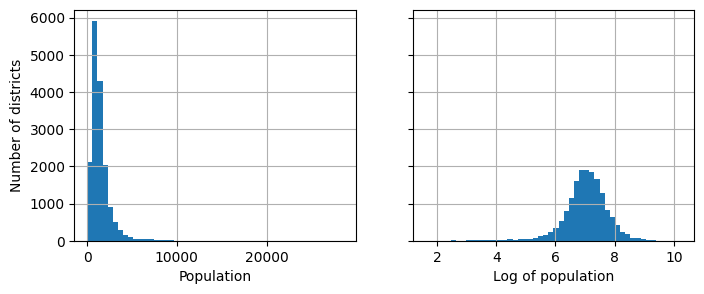

In [105]:
# Using log to ompress large and small positive numbers into a more manageable range

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

Another approach to handle heavy-tailed features - *bucketizing*
- Divide distribution into roughly equal-sized buckets
- Replace feature value with the index of the bucket

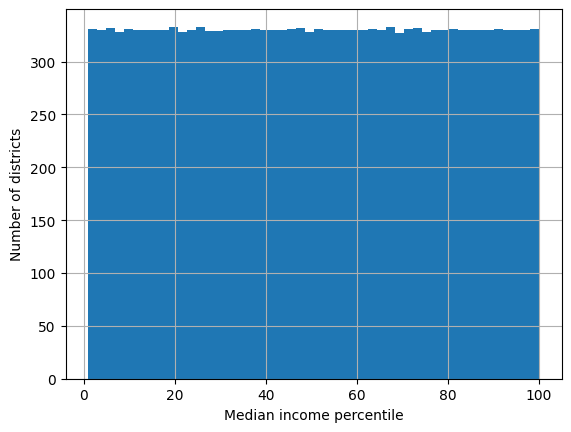

In [106]:
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

Multimodal Distribution
- Two or more distinct peaks, each representing a local maximum in the data's frequency or density function
- Can add feature for each of the peaks (at least the main ones) to transform it
  


In [107]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

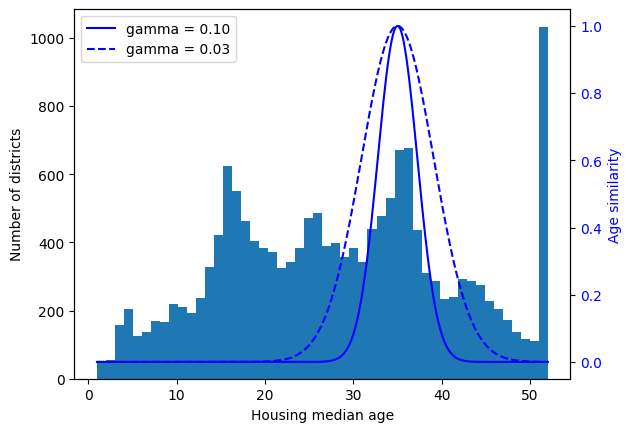

In [108]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")

plt.show()

In [111]:
# Using inverse_transform() to compute the inverse of transformations for the predicted output

from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

predictions

array([[203305.93689037],
       [170537.79615493],
       [209454.70770019],
       [471861.30394736],
       [125636.58709313]])

In [112]:
# Simpler option is to use TransformedTargetRegressor

from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

predictions

array([203305.93689037, 170537.79615493, 209454.70770019, 471861.30394736,
       125636.58709313])